In [1]:
# ===============================================================
# 0) Imports & Global Configuration
# ===============================================================
import os
import json
import warnings
import itertools
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests

import optuna
from joblib import dump

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# ------------------ Global constants ------------------
RANDOM_BASE = 42
N_REPS = 20

# 65/15/20 global split -> inner (train,val) over trainval(80%)
TEST_FRACTION = 0.20
VAL_FRACTION_GLOBAL = 0.15
val_in_trainval   = VAL_FRACTION_GLOBAL / (1.0 - TEST_FRACTION)   # 0.1875
train_in_trainval = 1.0 - val_in_trainval                         # 0.8125

# Feature selection bounds (k-Best)
K_MIN = 5
K_MAX = 12

# Optuna target: "ap" (PR-AUC), "f1", or "auc"
OPTIMIZE_FOR = "ap"   # <<< set "ap" as requested (can be "f1"/"auc")

# Optuna trials per model
N_TRIALS_BY_MODEL = {
    "Random Forest": 150,
    "SVM":           150,
    "MLP":           150,
    "XGBoost":       150,
    "KNN":           150,
    "Bagging":       150,
}

# Paths (set to your environment)
BASE_OUT_DIR = Path(r"C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3")
RUN_TAG      = f"OBJ_{OPTIMIZE_FOR}"
MODEL_DIR    = BASE_OUT_DIR / f"models_{RUN_TAG}"
OUT_DIR      = BASE_OUT_DIR / f"outputs_{RUN_TAG}"
EXPL_DIR     = BASE_OUT_DIR / f"explanations_plots_{RUN_TAG}"
LIME_DIR     = EXPL_DIR / "lime_html"
STATS_PLOTS  = BASE_OUT_DIR / f"stats_plots_{RUN_TAG}"
for d in [BASE_OUT_DIR, MODEL_DIR, OUT_DIR, EXPL_DIR, LIME_DIR, STATS_PLOTS]:
    d.mkdir(parents=True, exist_ok=True)

# Data path
DATA_XLS_PATH = r"C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\DS1\SUITABLE\TN Morfolojik_ALL_eng.xlsx"

SAVE_MODELS = True
DO_EDA_PLOTS = True
DO_EXPLAINERS = True

optuna.logging.set_verbosity(optuna.logging.WARNING)



c:\Users\gokalp\.conda\envs\myworksv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# ===============================================================
# 1) Load Data
# ===============================================================
data = pd.read_excel(DATA_XLS_PATH)
if "CLASS" not in data.columns:
    raise ValueError("Expected binary target column named 'CLASS' in the dataset.")

y = data["CLASS"].values
X = data.drop(columns=["CLASS"])

classes_sorted = np.unique(y)
if len(classes_sorted) != 2:
    raise ValueError(f"Binary classification expected; got {len(classes_sorted)} classes.")
neg_label, pos_label = classes_sorted[0], classes_sorted[1]

In [ ]:
# ===============================================================
# 2) Preprocessing (leakage-free in Pipeline)
# ===============================================================
def build_preprocessor_all_robust(X_train: pd.DataFrame) -> ColumnTransformer:
    """
    Apply RobustScaler feature-wise to ALL columns. Fit happens inside the pipeline.
    """
    cols = list(X_train.columns)
    return ColumnTransformer([('rob_all', RobustScaler(), cols)], remainder='drop')

def clean_names(names):
    """
    Remove transformer prefixes like 'rob_all__Age' -> 'Age' for readability.
    """
    out = []
    for n in names:
        try:
            out.append(n.split("__", 1)[1] if "__" in n else n)
        except Exception:
            out.append(str(n))
    return out

In [21]:
# ===============================================================
# 3) Optional EDA (correlations & class-wise boxplots)
# ===============================================================
if DO_EDA_PLOTS:
    try:
        # ---------- Correlation Heatmap ----------
        num_cols = X.select_dtypes(include=[np.number]).columns
        corr = X[num_cols].corr()

        plt.figure(figsize=(12, 8))
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
        plt.title("Correlation Heatmap (Numeric Features, Before Preprocessing)", fontsize=16, fontweight='semibold')
        plt.xlabel("Features", fontsize=13)
        plt.ylabel("Features", fontsize=13)
        plt.tight_layout()
        plt.savefig(OUT_DIR / "eda_correlation_heatmap.png", dpi=200)
        plt.close()

        # ---------- Class-wise Boxplots ----------
        feats = [col for col in num_cols if col.lower() != "sex"]  # ✅ 'Sex' hariç tut
        if len(feats) > 0:
            n = len(feats)
            n_cols = 3
            n_rows = int(np.ceil(n / n_cols))
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3.5*n_rows))
            axes = axes.ravel() if n_rows * n_cols > 1 else [axes]

            last_i = 0
            for i, col in enumerate(feats):
                ax = axes[i]
                d0 = data.loc[data["CLASS"] == neg_label, col].dropna()
                d1 = data.loc[data["CLASS"] == pos_label, col].dropna()

                # Boxplot
                ax.boxplot(
                    [d0, d1],
                    labels=["Asymptomatic Control", "Symptomatic iTN"],
                    showfliers=True,
                    patch_artist=True,
                    boxprops=dict(facecolor='#D0E4F5')
                )

                # Title & labels
                ax.set_title(col, fontsize=12, fontweight='semibold')
                ax.set_ylabel("Feature Value", fontsize=14)
                ax.tick_params(axis='x', labelsize=12)
                ax.tick_params(axis='y', labelsize=14)
                ax.grid(axis='y', linestyle=':', linewidth=0.4)

                # Alt açıklamaları büyüt
                for tick in ax.get_xticklabels():
                    tick.set_fontweight('bold')
                    tick.set_fontsize(12)
                    tick.set_color('#2B2B2B')

                last_i = i

            # Disable unused subplots
            for j in range(last_i + 1, len(axes)):
                axes[j].axis("off")

            # Figure title
            fig.suptitle(
                "Boxplots by Group (Asymptomatic Control vs Symptomatic iTN)",
                y=1.02,
                fontsize=22,
                fontweight='bold'
            )

            plt.tight_layout()
            plt.savefig(OUT_DIR / "eda_boxplots_by_group.png", dpi=300, bbox_inches='tight')
            plt.close()

    except Exception as e:
        warnings.warn(f"EDA plotting skipped due to error: {e}")


In [5]:
# ===============================================================
# 4) Utility Functions (metrics, CI, stats, plotting helpers)
# ===============================================================
def safe_div(a, b):
    return np.nan if b == 0 else a / b

def compute_row_metrics(tn, fp, fn, tp):
    """
    From raw confusion entries compute sensitivity, specificity, precision, recall,
    F1, MCC, G-mean, accuracy.
    """
    tn = float(tn); fp = float(fp); fn = float(fn); tp = float(tp)
    sens = safe_div(tp, tp + fn)
    spec = safe_div(tn, tn + fp)
    prec = safe_div(tp, tp + fp)
    rec  = sens
    f1 = np.nan if (np.isnan(prec) or np.isnan(rec) or (prec + rec) == 0) else (2 * prec * rec / (prec + rec))
    denom_mcc = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc = np.nan if denom_mcc <= 0 else ((tp * tn) - (fp * fn)) / np.sqrt(denom_mcc)
    gmean = np.nan if (np.isnan(sens) or np.isnan(spec)) else np.sqrt(sens * spec)
    total = tn + fp + fn + tp
    acc = safe_div(tn + tp, total)
    return sens, spec, prec, rec, f1, mcc, gmean, acc

def mean_std_ci_t(x, alpha=0.05):
    """
    t-based CI for 1D array (NaNs removed).
    """
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = x.size
    m = float(np.mean(x)) if n > 0 else np.nan
    s = float(np.std(x, ddof=1)) if n > 1 else np.nan
    if n > 1:
        tcrit = st.t.ppf(1 - alpha/2, df=n-1)
        half = tcrit * s / np.sqrt(n)
        lo, hi = m - half, m + half
    else:
        lo, hi = np.nan, np.nan
    return m, s, lo, hi, int(n)

def paired_ttest_ci(a, b, alpha=0.05):
    """
    Paired t-test with CI: returns n, mean_diff (A-B), CI, t, p
    """
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    n_all = min(a.size, b.size)
    a = a[:n_all]; b = b[:n_all]
    mask = (~np.isnan(a)) & (~np.isnan(b))
    a = a[mask]; b = b[mask]
    n = a.size
    if n <= 1:
        return {'n': int(n), 'mean_diff': np.nan, 'ci95': (np.nan, np.nan), 't': np.nan, 'p': np.nan}
    d = a - b
    md = float(np.mean(d))
    sd = float(np.std(d, ddof=1))
    tstat, pval = st.ttest_1samp(d, popmean=0.0)
    tcrit = st.t.ppf(1 - alpha/2, df=n - 1)
    half = tcrit * sd / np.sqrt(n)
    ci = (md - half, md + half)
    return {'n': int(n), 'mean_diff': md, 'ci95': ci, 't': float(tstat), 'p': float(pval)}

def friedman_and_pairwise(df_long, metric, alpha=0.05):
    """
    Friedman + pairwise Wilcoxon. Returns friedman summary and pairwise table with p_raw, mean_diff.
    """
    pivot = df_long.pivot_table(index='run', columns='model', values=metric)
    pivot = pivot.dropna(axis=0, how='any')
    models = list(pivot.columns)
    if len(models) < 2 or pivot.shape[0] < 2:
        empty = {'friedman': {'stat': np.nan, 'p': np.nan, 'k': len(models), 'n': pivot.shape[0]}}
        return empty, pd.DataFrame(columns=['metric','model_a','model_b','p_raw','mean_diff','p_holm','better_model'])

    stat, p = friedmanchisquare(*[pivot[m].values for m in models])
    fried = {'stat': stat, 'p': p, 'k': len(models), 'n': pivot.shape[0]}

    rows = []
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            a, b = models[i], models[j]
            vals_a, vals_b = pivot[a].values, pivot[b].values
            try:
                _, p_raw = wilcoxon(vals_a, vals_b, zero_method='wilcox',
                                    correction=False, alternative='two-sided', mode='auto')
                diff_mean = float(np.mean(vals_a - vals_b))
            except ValueError:
                p_raw, diff_mean = np.nan, np.nan
            rows.append([metric, a, b, p_raw, diff_mean])
    pw = pd.DataFrame(rows, columns=['metric','model_a','model_b','p_raw','mean_diff'])

    mask = ~pw['p_raw'].isna()
    if mask.any():
        _, p_holm, _, _ = multipletests(pw.loc[mask, 'p_raw'].values, method='holm')
        pw.loc[mask, 'p_holm'] = p_holm
    else:
        pw['p_holm'] = np.nan

    pw['better_model'] = np.where(
        pw['mean_diff'] > 0, pw['model_a'],
        np.where(pw['mean_diff'] < 0, pw['model_b'], 'equal')
    )
    return {'friedman': fried}, pw

def normalize_cm(cm, mode=None):
    cm = np.asarray(cm, dtype=float)
    if mode is None:
        return cm
    if mode == "row":
        row_sum = cm.sum(axis=1, keepdims=True)
        row_sum[row_sum == 0] = 1.0
        return cm / row_sum
    if mode == "all":
        s = cm.sum()
        return cm / s if s > 0 else cm
    raise ValueError("normalize mode must be None, 'row' or 'all'.")

def format_cell(mean, std, normalized):
    return f"{mean:.3f}±{std:.3f}" if normalized else f"{mean:.1f}±{std:.1f}"

def aggregate_cm_mean_std(df_conf_all, normalize=None):
    out = {}
    for model, g in df_conf_all.groupby("model"):
        mats = []
        for _, r in g.iterrows():
            cm = np.array([[r['tn'], r['fp']], [r['fn'], r['tp']]], dtype=float)
            mats.append(normalize_cm(cm, normalize))
        if not mats:
            continue
        arr = np.stack(mats, axis=0)
        out[model] = {
            'mean': arr.mean(axis=0),
            'std':  arr.std(axis=0, ddof=1) if arr.shape[0] > 1 else np.zeros((2,2)),
            'n':    int(arr.shape[0])
        }
    return out

def plot_confusion_mean_std(agg, normalize=None, classes=None, out_path=None, cmap="Blues"):
    """
    Annotated confusion matrices (mean±std) for all models.
    """
    models = list(agg.keys())
    if not models:
        raise ValueError("No models to plot.")
    n = len(models)
    n_cols = min(3, n)
    n_rows = int(np.ceil(n / n_cols))
    figsize = (5*n_cols, 4.5*n_rows)
    normalized = (normalize is not None)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = np.array([axes])
    elif n_cols == 1:
        axes = np.array([[ax] for ax in axes])

    vmin, vmax = (0.0, 1.0) if normalized else (None, None)

    idx = 0
    for r in range(n_rows):
        for c in range(n_cols):
            ax = axes[r, c]
            if idx >= n:
                ax.axis("off"); continue
            model = models[idx]
            M, S, n_runs = agg[model]['mean'], agg[model]['std'], agg[model]['n']
            ax.imshow(M, cmap=cmap, vmin=vmin, vmax=vmax)
            for i in range(2):
                for j in range(2):
                    ax.text(j, i, format_cell(M[i, j], S[i, j], normalized),
                            color="black", ha="center", va="center", fontsize=14)

            ticklabels = [str(classes[0]), str(classes[1])] if classes is not None else ["Neg","Pos"]
            ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
            ax.set_xticklabels([f"Pred {ticklabels[0]}", f"Pred {ticklabels[1]}"])
            ax.set_yticklabels([f"True {ticklabels[0]}", f"True {ticklabels[1]}"])
            ax.set_title(f"{model} — mean±std  (n={n_runs})")
            ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
            ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
            ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
            ax.tick_params(which='minor', bottom=False, left=False)
            idx += 1

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    mappable = axes[0,0].images[0]
    fig.colorbar(mappable, cax=cbar_ax)
    supt = "Confusion Matrices — mean ± std"
    if normalize == "row": supt += " (row-normalized)"
    elif normalize == "all": supt += " (global-normalized)"
    fig.suptitle(supt, y=0.98, fontsize=14)
    fig.tight_layout(rect=[0, 0, 0.90, 0.97])
    if out_path is not None:
        fig.savefig(out_path, dpi=200)
    plt.close(fig)

In [6]:
# ===============================================================
# 5) Optuna Objective & Param Sanitization
# ===============================================================
def objective(trial, model_name, X_train, y_train, X_val, y_val, preprocessor_fixed, seed=None):
    """
    Build model, add SelectKBest, fit on TRAIN and return selected validation objective
    (F1, AP, or AUC). Also logs other validation metrics into trial.user_attrs.
    """
    rng_seed = (RANDOM_BASE if seed is None else int(seed))

    # ---------------- Classifier space ----------------
    if model_name == "Random Forest":
        params = {
            'n_estimators':       trial.suggest_int('n_estimators', 200, 1000, step=100),
            'max_depth':          trial.suggest_int('max_depth', 2, 30),
            'min_samples_split':  trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf':   trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features':       trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'criterion':          trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
            'bootstrap':          trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight':       'balanced',
            'n_jobs':            -1,
            'random_state':       rng_seed
        }
        clf = RandomForestClassifier(**params)

    elif model_name == "SVM":
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        params = {
            'C':            trial.suggest_float('C', 1e-3, 1e3, log=True),
            'kernel':       kernel,
            'class_weight': 'balanced',
            'probability':  True,
            'random_state': rng_seed,
        }
        if kernel in ('rbf', 'poly'):
            gm = trial.suggest_categorical('gamma_mode', ['scale', 'auto', 'float'])
            params['gamma'] = trial.suggest_float('gamma', 1e-4, 1.0, log=True) if gm == 'float' else gm
        if kernel == 'poly':
            params['degree'] = trial.suggest_int('degree', 2, 5)
        clf = SVC(**params)

    elif model_name == "MLP":
        solver = trial.suggest_categorical('solver', ['adam', 'lbfgs'])
        params = {
            'hidden_layer_sizes': trial.suggest_categorical(
                'hidden_layer_sizes', [(20,10,5), (15,15,5), (20,15,5), (20,10)]
            ),
            'activation':   trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
            'alpha':        trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
            'solver':       solver,
            'max_iter':     trial.suggest_int('max_iter', 400, 1200, step=100),
            'random_state': rng_seed,
        }
        if solver == 'adam':
            params.update({
                'learning_rate':      trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
                'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-5, 1e-3, log=True),
                'beta_1':             trial.suggest_float('beta_1', 0.7, 0.99),
                'beta_2':             trial.suggest_float('beta_2', 0.9, 0.999),
                'early_stopping':     trial.suggest_categorical('early_stopping', [True, False]),
                'batch_size':         trial.suggest_categorical('batch_size', [16, 32, 64]),
            })
        clf = MLPClassifier(**params)

    elif model_name == "XGBoost":
        pos_n = int(np.sum(y_train == pos_label))
        neg_n = int(np.sum(y_train != pos_label))
        spw_base = (neg_n / max(1, pos_n)) if pos_n > 0 else 1.0
        params = {
            'n_estimators':      trial.suggest_int('n_estimators', 200, 1000, step=100),
            'max_depth':         trial.suggest_int('max_depth', 2, 10),
            'learning_rate':     trial.suggest_float('learning_rate', 1e-3, 3e-1, log=True),
            'subsample':         trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight':  trial.suggest_float('min_child_weight', 1e-1, 10.0, log=True),
            'gamma':             trial.suggest_float('gamma', 0.0, 5.0),
            'reg_alpha':         trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda':        trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            'scale_pos_weight':  trial.suggest_float('scale_pos_weight', spw_base*0.5, spw_base*2.0, log=True),
            'n_jobs':           -1,
            'random_state':      rng_seed,
            'eval_metric':       'logloss',
            'tree_method':       'hist',
        }
        clf = XGBClassifier(**params)

    elif model_name == "KNN":
        params = {
            "n_neighbors": trial.suggest_int("n_neighbors", 1, 30),
            "weights":     trial.suggest_categorical("weights", ["uniform", "distance"]),
            "p":           trial.suggest_int("p", 1, 2),
            "leaf_size":   trial.suggest_int("leaf_size", 10, 60),
            "metric":      trial.suggest_categorical("metric", ["minkowski", "euclidean", "manhattan"]),
        }
        clf = KNeighborsClassifier(**params)

    elif model_name == "Bagging":
        base_choice = trial.suggest_categorical("base_estimator", ["tree", "knn"])
        if base_choice == "tree":
            base_est = DecisionTreeClassifier(
                max_depth=trial.suggest_int("max_depth", 1, 15),
                min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 5),
                class_weight='balanced',
                random_state=rng_seed
            )
        else:
            base_est = KNeighborsClassifier(
                n_neighbors=trial.suggest_int("n_neighbors", 3, 15),
                weights=trial.suggest_categorical("weights", ["uniform", "distance"])
            )
        params = {
            "n_estimators":       trial.suggest_int("n_estimators", 10, 200, step=10),
            "max_samples":        trial.suggest_float("max_samples", 0.5, 1.0),
            "max_features":       trial.suggest_float("max_features", 0.5, 1.0),
            "bootstrap":          trial.suggest_categorical("bootstrap", [True, False]),
            "bootstrap_features": trial.suggest_categorical("bootstrap_features", [False, True]),
            "n_jobs":            -1,
            "random_state":       rng_seed,
        }
        clf = BaggingClassifier(estimator=base_est, **params)

    else:
        raise ValueError(f"Unknown model: {model_name}")

    # ---------------- Feature selector (k) ----------------
    n_out_after_prep = X_train.shape[1]  # RobustScaler keeps dimensionality
    k_min_eff = int(max(1, min(K_MIN, n_out_after_prep)))
    k_max_eff = int(min(K_MAX, n_out_after_prep))
    if k_max_eff < k_min_eff:
        k_max_eff = k_min_eff
    k_best = trial.suggest_int('k_best', k_min_eff, k_max_eff)

    selector = SelectKBest(score_func=f_classif, k=k_best)

    # ---------------- Full pipeline ----------------
    pipe = Pipeline([('prep', preprocessor_fixed),
                     ('feat', selector),
                     ('clf', clf)])
    pipe.fit(X_train, y_train)

    # Validation predictions
    y_pred = pipe.predict(X_val)
    f1_val = f1_score(y_val, y_pred, average="binary", pos_label=pos_label)

    # Need probabilities for AP/AUC
    proba_val = pipe.predict_proba(X_val)[:, int(np.where(pipe.named_steps["clf"].classes_ == pos_label)[0][0])]
    ap_val  = average_precision_score(y_val, proba_val)
    auc_val = roc_auc_score(y_val, proba_val)

    # Log all val metrics
    trial.set_user_attr("val_f1",  float(f1_val))
    trial.set_user_attr("val_ap",  float(ap_val))
    trial.set_user_attr("val_auc", float(auc_val))

    # Return the chosen objective
    if OPTIMIZE_FOR.lower() == "ap":
        return ap_val
    elif OPTIMIZE_FOR.lower() == "auc":
        return auc_val
    else:
        return f1_val


def sanitize_params_for_final(model_name, best_params_all):
    """
    Remove pipeline-only params (k_best/gamma_mode/etc.) and return
    (clean_params, base_choice_for_bagging).
    """
    p = best_params_all.copy()

    # Universal removals
    for k in ["k_best", "k_features"]:
        p.pop(k, None)

    if model_name == "SVM":
        gm = p.pop("gamma_mode", None)
        if gm in ("scale", "auto"):
            p["gamma"] = gm

    if model_name == "Bagging":
        base_choice = p.pop("base_estimator", None)
        allowed = {"n_estimators", "max_samples", "max_features",
                   "bootstrap", "bootstrap_features", "n_jobs", "random_state"}
        p = {k: v for k, v in p.items() if k in allowed}
        return p, base_choice

    return p, None


def get_selected_feature_info(fitted_pipe: Pipeline, X_ref: pd.DataFrame):
    """
    Return selected-mask and feature names after 'prep' (and after selection),
    plus cleaned names (without transformer prefixes).
    """
    pre = fitted_pipe.named_steps.get('prep', None)
    feat = fitted_pipe.named_steps.get('feat', None)
    try:
        base_names = list(pre.get_feature_names_out(input_features=X_ref.columns))
    except Exception:
        try:
            base_names = list(pre.get_feature_names_out())
        except Exception:
            base_names = list(X_ref.columns)

    mask = None
    if feat is not None and hasattr(feat, "get_support"):
        mask = feat.get_support()
        sel_names = list(np.array(base_names)[mask])
    else:
        sel_names = base_names

    sel_names_clean = clean_names(sel_names)
    return mask, sel_names, sel_names_clean, base_names

In [7]:
# ===============================================================
# 6) Main Loop: Splits + Optuna + Test Evaluation
# ===============================================================
model_names = ["Random Forest", "SVM", "MLP", "XGBoost", "KNN", "Bagging"]

best_hyperparameters    = {m: [] for m in model_names}
selected_features_store = {m: {} for m in model_names}

test_confusions = {m: [] for m in model_names}
test_roc_curves = {m: [] for m in model_names}  # list of (fpr, tpr, auc)
test_pr_curves  = {m: [] for m in model_names}  # list of (recall, precision, ap)

test_auc_list   = {m: [] for m in model_names}
test_ap_list    = {m: [] for m in model_names}
test_f1_list    = {m: [] for m in model_names}

final_pipes     = {m: {} for m in model_names}
saved_model_paths = {m: [] for m in model_names}
split_store     = {}
ap_records      = []

for rep in range(N_REPS):
    seed_outer = int(RANDOM_BASE + 10007*rep + 13)
    seed_inner = int(RANDOM_BASE + 20011*rep + 97)
    seed_model = int(RANDOM_BASE + 30029*rep + 211)
    seed_tpe   = int(RANDOM_BASE + 40039*rep + 509)

    # Outer split (20% test)
    outer = StratifiedShuffleSplit(n_splits=1, test_size=TEST_FRACTION, random_state=seed_outer)
    (trainval_idx, test_idx), = outer.split(X, y)
    X_trainval, y_trainval = X.iloc[trainval_idx], y[trainval_idx]
    X_test,     y_test     = X.iloc[test_idx],     y[test_idx]
    split_store[rep] = {"trainval_idx": trainval_idx.tolist(), "test_idx": test_idx.tolist()}

    # Inner split (train/val)
    inner = StratifiedShuffleSplit(n_splits=1, train_size=train_in_trainval,
                                   test_size=val_in_trainval, random_state=seed_inner)
    (tr_idx, val_idx), = inner.split(X_trainval, y_trainval)
    X_train, y_train = X_trainval.iloc[tr_idx], y_trainval[tr_idx]
    X_val,   y_val   = X_trainval.iloc[val_idx], y_trainval[val_idx]

    PREPROC = build_preprocessor_all_robust(X_train)

    for model_name in model_names:
        # ---- Optuna study ----
        study = optuna.create_study(
            direction="maximize",
            sampler=optuna.samplers.TPESampler(seed=seed_tpe),
            pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
        )
        study.optimize(
            lambda tr: objective(tr, model_name, X_train, y_train, X_val, y_val,
                                 preprocessor_fixed=PREPROC, seed=seed_model),
            n_trials=N_TRIALS_BY_MODEL.get(model_name, 150),
            n_jobs=1,
        )

        best_params_all = study.best_params.copy()
        # pull all val metrics from best trial
        bt = study.best_trial
        best_val_f1  = float(bt.user_attrs.get("val_f1", np.nan))
        best_val_ap  = float(bt.user_attrs.get("val_ap", np.nan))
        best_val_auc = float(bt.user_attrs.get("val_auc", np.nan))

        best_hyperparameters[model_name].append({
            "rep": rep,
            "best_params": best_params_all.copy(),
            "val_f1":  best_val_f1,
            "val_ap":  best_val_ap,
            "val_auc": best_val_auc,
            "optimize_for": OPTIMIZE_FOR
        })

        clean_params, base_choice = sanitize_params_for_final(model_name, best_params_all)
        k_best = int(best_params_all.get("k_best", min(K_MAX, X_train.shape[1])))

        # ---- Final model on TRAIN+VAL ----
        if model_name == "Random Forest":
            clf_best = RandomForestClassifier(
                **clean_params, n_jobs=-1, class_weight='balanced', random_state=seed_model
            )
        elif model_name == "SVM":
            clf_best = SVC(
                probability=True, **clean_params, class_weight='balanced', random_state=seed_model
            )
        elif model_name == "MLP":
            clf_best = MLPClassifier(**clean_params, random_state=seed_model)
        elif model_name == "XGBoost":
            clf_best = XGBClassifier(eval_metric="logloss", n_jobs=-1, random_state=seed_model, **clean_params)
        elif model_name == "KNN":
            clf_best = KNeighborsClassifier(**clean_params)
        elif model_name == "Bagging":
            if base_choice is None:
                base_choice = best_params_all.get("base_estimator", "tree")
            if base_choice == "tree":
                base_est = DecisionTreeClassifier(
                    max_depth=best_params_all.get("max_depth", None),
                    min_samples_split=best_params_all.get("min_samples_split", 2),
                    min_samples_leaf=best_params_all.get("min_samples_leaf", 1),
                    class_weight='balanced',
                    random_state=seed_model,
                )
            else:
                base_est = KNeighborsClassifier(
                    n_neighbors=best_params_all.get("n_neighbors", 5),
                    weights=best_params_all.get("weights", "uniform")
                )
            bag_params = {k: v for k, v in best_params_all.items() if k in {
                "n_estimators", "max_samples", "max_features",
                "bootstrap", "bootstrap_features", "n_jobs", "random_state"
            }}
            clf_best = BaggingClassifier(estimator=base_est, random_state=seed_model, **bag_params)

            best_hyperparameters[model_name][-1]["best_params_structured"] = {
                "bagging": bag_params,
                "base_estimator": base_choice
            }
        else:
            raise ValueError(f"Unknown model: {model_name}")

        selector_final = SelectKBest(score_func=f_classif, k=k_best)
        final_pipe = Pipeline([("prep", PREPROC), ("feat", selector_final), ("clf", clf_best)])
        final_pipe.fit(X_trainval, y_trainval)

        # ---- Save selected features ----
        mask, sel_names, sel_names_clean, base_names = get_selected_feature_info(final_pipe, X)
        selected_features_store[model_name][rep] = {
            "k_best": int(k_best),
            "mask_after_prep": None if mask is None else mask.astype(bool).tolist(),
            "selected_feature_names_after_prep": sel_names,
            "selected_feature_names_clean": sel_names_clean,
            "base_feature_names_after_prep": base_names,
            "f_scores_all": getattr(selector_final, "scores_", None).tolist() if getattr(selector_final, "scores_", None) is not None else None,
            "p_values_all": getattr(selector_final, "pvalues_", None).tolist() if getattr(selector_final, "pvalues_", None) is not None else None
        }
        best_hyperparameters[model_name][-1]["k_best"] = int(k_best)
        best_hyperparameters[model_name][-1]["selected_feature_names_clean"] = sel_names_clean

        # ---- Test evaluation ----
        pos_idx    = int(np.where(final_pipe.named_steps["clf"].classes_ == pos_label)[0][0])
        proba_test = final_pipe.predict_proba(X_test)[:, pos_idx]
        auc_test   = roc_auc_score(y_test, proba_test)
        ap_test    = average_precision_score(y_test, proba_test)
        y_pred     = final_pipe.predict(X_test)
        f1_test    = f1_score(y_test, y_pred, average="binary", pos_label=pos_label)

        cm   = confusion_matrix(y_test, y_pred, labels=classes_sorted)
        fpr, tpr, _ = roc_curve(y_test, proba_test, pos_label=pos_label)
        prec, rec, _ = precision_recall_curve(y_test, proba_test, pos_label=pos_label)

        test_confusions[model_name].append(cm)
        test_roc_curves[model_name].append((fpr, tpr, auc_test))
        test_pr_curves[model_name].append((rec, prec, ap_test))
        test_auc_list[model_name].append(float(auc_test))
        test_ap_list[model_name].append(float(ap_test))
        test_f1_list[model_name].append(float(f1_test))

        final_pipes[model_name][rep] = final_pipe
        ap_records.append({
            "model": model_name, "rep": rep,
            "auc_test": float(auc_test), "ap_test":  float(ap_test), "f1_test":  float(f1_test),
            "val_f1":   float(best_val_f1), "val_ap": float(best_val_ap), "val_auc": float(best_val_auc),
            "optimize_for": OPTIMIZE_FOR
        })

        if SAVE_MODELS:
            safe_model = model_name.replace(" ", "")
            fname = MODEL_DIR / f"{safe_model}__rep{rep:02d}__OBJ{OPTIMIZE_FOR}__F1{f1_test:.4f}__AUC{auc_test:.4f}__AP{ap_test:.4f}.joblib"
            dump(final_pipe, fname, compress=3)
            saved_model_paths[model_name].append(str(fname))

c:\Users\gokalp\.conda\envs\myworksv2\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (20, 10, 5) which is of type tuple.
  warnings.warn(message)
c:\Users\gokalp\.conda\envs\myworksv2\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (15, 15, 5) which is of type tuple.
  warnings.warn(message)
c:\Users\gokalp\.conda\envs\myworksv2\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (20, 15, 5) which is of type tuple.
  warnings.warn(message)
c:\Users\gokalp\.conda\envs\myworksv2\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution shoul

In [8]:
# ===============================================================
# 7) Run-level Tables, Summaries, ROC/PR(mean±std)
# ===============================================================
df_scores = pd.DataFrame(ap_records).sort_values(["model", "f1_test"]).reset_index(drop=True)
df_scores.to_csv(OUT_DIR / "scores_f1_runs.csv", index=False)

df_scores_ap = pd.DataFrame(ap_records).sort_values(["model", "ap_test"]).reset_index(drop=True)
df_scores_ap.to_csv(OUT_DIR / "scores_pr_auc_runs.csv", index=False)

# Summary table (mean±std) for AUC/AP/F1
rows_sum = []
for m in model_names:
    rows_sum.append({
        "model":   m,
        "AUC_mean": np.mean(test_auc_list[m]) if test_auc_list[m] else np.nan,
        "AUC_std":  np.std(test_auc_list[m], ddof=1) if len(test_auc_list[m]) > 1 else 0.0,
        "AP_mean":  np.mean(test_ap_list[m]) if test_ap_list[m] else np.nan,
        "AP_std":   np.std(test_ap_list[m], ddof=1) if len(test_ap_list[m]) > 1 else 0.0,
        "F1_mean":  np.mean(test_f1_list[m]) if test_f1_list[m] else np.nan,
        "F1_std":   np.std(test_f1_list[m], ddof=1) if len(test_f1_list[m]) > 1 else 0.0,
        "N_reps":   len(test_auc_list[m])
    })
df_summary = pd.DataFrame(rows_sum)
df_summary.to_csv(OUT_DIR / "summary_mean_std.csv", index=False)

# Save best hyperparameters and selection info
with open(OUT_DIR / "best_hyperparameters.json", "w", encoding="utf-8") as f:
    json.dump(best_hyperparameters, f, ensure_ascii=False, indent=2)

with open(OUT_DIR / "selected_features_store.json", "w", encoding="utf-8") as f:
    json.dump(selected_features_store, f, ensure_ascii=False, indent=2)

dump({
    "test_confusions": test_confusions,
    "test_roc_curves": test_roc_curves,
    "test_pr_curves":  test_pr_curves,
    "test_auc_list":   test_auc_list,
    "test_ap_list":    test_ap_list,
    "test_f1_list":    test_f1_list,
    "split_store":     split_store,
    "saved_model_paths": saved_model_paths
}, OUT_DIR / "diagnostics.joblib", compress=3)

# ROC(mean±std) on a fixed FPR grid
fpr_grid = np.linspace(0, 1, 201)
plt.figure(figsize=(10, 8))
for m, curves in test_roc_curves.items():
    if not curves: continue
    interp_tprs = []
    for (fpr, tpr, _) in curves:
        tpr_i = np.interp(fpr_grid, fpr, tpr)
        tpr_i[0], tpr_i[-1] = 0.0, 1.0
        interp_tprs.append(tpr_i)
    interp_tprs = np.vstack(interp_tprs)
    mean_tpr = interp_tprs.mean(axis=0)
    std_tpr  = interp_tprs.std(axis=0, ddof=1)
    mean_auc = float(np.mean(test_auc_list[m])); std_auc = float(np.std(test_auc_list[m], ddof=1))
    plt.plot(fpr_grid, mean_tpr, label=f"{m} (AUC={mean_auc:.3f}±{std_auc:.3f})")
    plt.fill_between(fpr_grid, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1), alpha=0.15)
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'UNSEEN TEST — Mean ROC ± 1 std (20 repeats) — {RUN_TAG}')
plt.legend(loc='lower right'); plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR / "roc_mean_std.png", dpi=200)
plt.close()

# PR(mean±std) on a fixed recall grid
recall_grid = np.linspace(0, 1, 201)
plt.figure(figsize=(10, 8))
for m, curves in test_pr_curves.items():
    if not curves: continue
    interp_precs = []
    for (rec, prec, _) in curves:
        # ensure increasing recall for interpolation
        order = np.argsort(rec)
        rec_sorted = rec[order]; prec_sorted = prec[order]
        prec_i = np.interp(recall_grid, rec_sorted, prec_sorted, left=prec_sorted[0], right=prec_sorted[-1])
        interp_precs.append(prec_i)
    interp_precs = np.vstack(interp_precs)
    mean_prec = interp_precs.mean(axis=0)
    std_prec  = interp_precs.std(axis=0, ddof=1)
    mean_ap   = float(np.mean(test_ap_list[m])); std_ap = float(np.std(test_ap_list[m], ddof=1))
    plt.plot(recall_grid, mean_prec, label=f"{m} (AP={mean_ap:.3f}±{std_ap:.3f})")
    plt.fill_between(recall_grid, np.maximum(mean_prec - std_prec, 0), np.minimum(mean_prec + std_prec, 1), alpha=0.15)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title(f'UNSEEN TEST — Mean PR ± 1 std (20 repeats) — {RUN_TAG}')
plt.legend(loc='lower left'); plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR / "pr_mean_std.png", dpi=200)
plt.close()

print("\n[OK] Saved core outputs under:", OUT_DIR.resolve())


[OK] Saved core outputs under: C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\outputs_OBJ_ap


In [9]:
# ===============================================================
# 8) Confusion Matrices (All runs) + Mean±Std Visualizations
# ===============================================================
rows_all = []
for model_name, cm_list in test_confusions.items():
    for rep0, cm in enumerate(cm_list):
        cm = np.asarray(cm)
        if cm.shape != (2, 2):
            raise ValueError(f"[{model_name}] rep={rep0}: Confusion matrix shape {cm.shape} is not 2x2.")
        tn, fp = int(cm[0, 0]), int(cm[0, 1])
        fn, tp = int(cm[1, 0]), int(cm[1, 1])
        rows_all.append({"model": model_name, "run": rep0 + 1, "tn": tn, "fp": fp, "fn": fn, "tp": tp})

df_conf_all = pd.DataFrame(rows_all, columns=["model", "run", "tn", "fp", "fn", "tp"])
df_conf_all.to_excel(BASE_OUT_DIR / f"unseen_confusions_allruns_{RUN_TAG}.xlsx", sheet_name="confusions_allruns", index=False)
df_conf_all.to_csv  (BASE_OUT_DIR / f"unseen_confusions_allruns_{RUN_TAG}.csv", index=False)

# Mean±std confusion plots (raw, row-normalized, all-normalized)
for norm_tag in [None, "row", "all"]:
    agg = aggregate_cm_mean_std(df_conf_all, normalize=norm_tag)
    out_png = BASE_OUT_DIR / f"confusion_mean_std_{RUN_TAG}_{'raw' if norm_tag is None else norm_tag}.png"
    plot_confusion_mean_std(agg, normalize=norm_tag, classes=list(classes_sorted), out_path=out_png)
    print(f"[OK] Saved: {out_png}")


C:\Users\gokalp\AppData\Local\Temp\ipykernel_14376\2045511708.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.90, 0.97])


[OK] Saved: C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\confusion_mean_std_OBJ_ap_raw.png


C:\Users\gokalp\AppData\Local\Temp\ipykernel_14376\2045511708.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.90, 0.97])


[OK] Saved: C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\confusion_mean_std_OBJ_ap_row.png


C:\Users\gokalp\AppData\Local\Temp\ipykernel_14376\2045511708.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.90, 0.97])


[OK] Saved: C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\confusion_mean_std_OBJ_ap_all.png


In [10]:
# ===============================================================
# 9) Per-run Metrics + Friedman/Wilcoxon + Significance (Holm-gated)
# ===============================================================
ALPHA_SIG = 0.05      # Holm-corrected alpha
TIE_EPS   = 1e-12     # tie threshold for mean_diff

# Per-run metrics table
metrics_list = ['sensitivity','specificity','precision','recall','f1','mcc','gmean','accuracy']
mets = df_conf_all.apply(lambda r: compute_row_metrics(r['tn'], r['fp'], r['fn'], r['tp']), axis=1)
(df_conf_all['sensitivity'], df_conf_all['specificity'], df_conf_all['precision'], df_conf_all['recall'],
 df_conf_all['f1'], df_conf_all['mcc'], df_conf_all['gmean'], df_conf_all['accuracy']) = zip(*mets)

df_per_run = df_conf_all[['model','run','tn','fp','fn','tp'] + metrics_list].copy()
df_per_run.to_csv(OUT_DIR / "metrics_per_run_20.csv", index=False)

# Summary (mean ± std)
summary_20 = (df_per_run.groupby('model')[metrics_list].agg(['mean','std','count']).reset_index())
summary_20.columns = ['model'] + ['_'.join(col).strip() for col in summary_20.columns[1:]]
summary_20.to_csv(OUT_DIR / "metrics_summary_by_model_20.csv", index=False)

# Friedman + pairwise Wilcoxon(Holm), then build gated "winner/No/None"
friedman_rows = []
pairwise_all  = []

for mtr in metrics_list:
    df_long = df_per_run[['model','run', mtr]].copy()
    res, pw_raw = friedman_and_pairwise(df_long, mtr)

    pw = pw_raw.copy()
    # Direction raw
    pw['direction_raw'] = np.where(
        pw['mean_diff'] >  TIE_EPS, pw['model_a'],
        np.where(pw['mean_diff'] < -TIE_EPS, pw['model_b'], 'tie')
    )

    # Recompute Holm to be safe
    mask = ~pw['p_raw'].isna()
    if mask.any():
        _, p_holm, _, _ = multipletests(pw.loc[mask, 'p_raw'].values, method='holm')
        pw.loc[mask, 'p_holm'] = p_holm
    else:
        pw['p_holm'] = np.nan

    # Winner labeling (Holm-gated)
    # - significant & mean_diff>0  -> model_a wins
    # - significant & mean_diff<0  -> model_b wins
    # - not significant            -> "No"
    # - no data (p_holm NaN)       -> "None"
    winner_report = []
    for _, r in pw.iterrows():
        if pd.isna(r['p_holm']):
            winner_report.append("None")
        elif r['p_holm'] < ALPHA_SIG:
            if r['mean_diff'] >  TIE_EPS: winner_report.append(r['model_a'])
            elif r['mean_diff'] < -TIE_EPS: winner_report.append(r['model_b'])
            else: winner_report.append("No")
        else:
            winner_report.append("No")
    pw['winner'] = winner_report

    friedman_rows.append({
        'metric': mtr, 'friedman_stat': res['friedman']['stat'],
        'friedman_p': res['friedman']['p'], 'k_models': res['friedman']['k'],
        'n_runs': res['friedman']['n']
    })
    pairwise_all.append(pw)

df_friedman_20 = pd.DataFrame(friedman_rows)
df_pairwise_20 = pd.concat(pairwise_all, ignore_index=True)

# Save CSVs
df_friedman_20.to_csv(OUT_DIR / "stats_friedman_20.csv", index=False)
df_pairwise_20.to_csv(OUT_DIR / "stats_pairwise_20_directional.csv", index=False)
print("[OK] Saved nonparametric stats (Friedman + Wilcoxon-Holm, gated winner).")

# Build model×model matrices (per metric) & save to Excel + plot PNGs
signif_xlsx = BASE_OUT_DIR / f"pairwise_matrices_significance_{RUN_TAG}.xlsx"
models_all = sorted(set(df_pairwise_20["model_a"]) | set(df_pairwise_20["model_b"]))

def _plot_matrix_text(M_df, title, out_png, cmap=None, highlight_mask=None):
    """
    Plot a text-annotated matrix (strings) with optional highlight mask.
    highlight_mask==True cells will be colored; others light.
    """
    # Map to numeric for a colormap background: highlight=1 else 0, diagonal NaN
    code = np.zeros(M_df.shape, dtype=float)
    txt = M_df.values.astype(str)
    for i in range(M_df.shape[0]):
        for j in range(M_df.shape[1]):
            if i == j:
                code[i, j] = np.nan
            else:
                if highlight_mask is not None and highlight_mask[i, j]:
                    code[i, j] = 1.0
                else:
                    code[i, j] = 0.0
    plt.figure(figsize=(1.2*M_df.shape[1], 1.0*M_df.shape[0]))
    ax = sns.heatmap(code, annot=txt, fmt="", cbar=False,
                     cmap=cmap if cmap else sns.color_palette(["#f0f0f0","#bfe3bf"], as_cmap=True),
                     linewidths=.5, linecolor='white')
    ax.set_xticklabels(M_df.columns, rotation=45, ha='right')
    ax.set_yticklabels(M_df.index, rotation=0)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

with pd.ExcelWriter(signif_xlsx) as writer:
    for mtr in metrics_list:
        sub = df_pairwise_20[df_pairwise_20["metric"] == mtr].copy()

        # Initialize matrices
        P = pd.DataFrame(np.nan, index=models_all, columns=models_all)  # pHolm
        M = pd.DataFrame("None", index=models_all, columns=models_all)  # winner/No/None

        # Fill
        for _, r in sub.iterrows():
            a, b, p, w = r["model_a"], r["model_b"], r["p_holm"], r["winner"]
            P.loc[a, b] = P.loc[b, a] = p
            M.loc[a, b] = M.loc[b, a] = w

        # Diagonals
        np.fill_diagonal(P.values, 0.0)
        np.fill_diagonal(M.values, "-")

        # Save sheets
        P.to_excel(writer, sheet_name=f"{mtr}_pHolm")
        M.to_excel(writer, sheet_name=f"{mtr}_sig")

        # ---- Also export PNG heatmaps for GitHub ----
        # 1) pHolm heatmap as -log10(p) (visual dynamic)
        P_plot = P.copy()
        with np.errstate(divide='ignore'):
            P_plot = -np.log10(P_plot)
        plt.figure(figsize=(1.2*len(models_all), 1.0*len(models_all)))
        ax = sns.heatmap(P_plot, cmap="mako", linewidths=.5, linecolor='white',
                         cbar_kws={'label': '-log10(pHolm)'})
        ax.set_xticklabels(P_plot.columns, rotation=45, ha='right')
        ax.set_yticklabels(P_plot.index, rotation=0)
        plt.title(f"{mtr} — pHolm (−log10) — {RUN_TAG}")
        plt.tight_layout()
        plt.savefig(STATS_PLOTS / f"{mtr}_pHolm_heatmap_{RUN_TAG}.png", dpi=200)
        plt.close()

        # 2) winner/No/None annotated matrix with significant cells highlighted
        # highlight = (winner not in {"No","None","-"} and off-diagonal)
        hl = np.zeros(M.shape, dtype=bool)
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                if i == j:
                    hl[i, j] = False
                else:
                    val = M.iloc[i, j]
                    hl[i, j] = (val not in {"No", "None", "-"})

        _plot_matrix_text(
            M, title=f"{mtr} — Winner/No/None — {RUN_TAG}",
            out_png=STATS_PLOTS / f"{mtr}_sig_winner_matrix_{RUN_TAG}.png",
            highlight_mask=hl
        )

print(f"[OK] Saved significance matrices & plots: {signif_xlsx}, {STATS_PLOTS}")


[OK] Saved nonparametric stats (Friedman + Wilcoxon-Holm, gated winner).
[OK] Saved significance matrices & plots: C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\pairwise_matrices_significance_OBJ_ap.xlsx, C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\stats_plots_OBJ_ap


In [11]:
# ===============================================================
# 10) 95% t-CI for ALL metrics + AUC/AP + Paired t-tests for AUC
# ===============================================================
ALPHA_CI = 0.05

# CI for per-run metrics
rows_ci = []
for model_name, g in df_per_run.groupby('model'):
    for mtr in metrics_list:
        m, s, lo, hi, n = mean_std_ci_t(g[mtr].values, alpha=ALPHA_CI)
        rows_ci.append({'model': model_name, 'metric': mtr, 'mean': m, 'std': s,
                        'ci95_low': lo, 'ci95_high': hi, 'n_runs_used': n})
df_ci_long = pd.DataFrame(rows_ci).sort_values(['model','metric']).reset_index(drop=True)
df_ci_long.to_csv(OUT_DIR / "metrics_ci95_by_model_20_long.csv", index=False)

# Wide variant
wide_rows = []
for model_name, g in df_per_run.groupby('model'):
    row = {'model': model_name}
    for mtr in metrics_list:
        m, s, lo, hi, n = mean_std_ci_t(g[mtr].values, alpha=ALPHA_CI)
        row[f"{mtr}_mean"] = m; row[f"{mtr}_std"] = s
        row[f"{mtr}_ci95_low"] = lo; row[f"{mtr}_ci95_high"] = hi; row[f"{mtr}_n"] = n
    wide_rows.append(row)
df_ci_wide = pd.DataFrame(wide_rows).sort_values('model').reset_index(drop=True)
df_ci_wide.to_csv(OUT_DIR / "metrics_ci95_by_model_20_wide.csv", index=False)

# CI for AUC and AP
rows_auc_ap = []
auc_src = {k: list(v) for k, v in test_auc_list.items()} if test_auc_list else {}
ap_src  = {k: list(v) for k, v in test_ap_list.items()}  if test_ap_list  else {}
for model, arr in auc_src.items():
    m, s, lo, hi, n = mean_std_ci_t(arr, alpha=ALPHA_CI)
    rows_auc_ap.append({'model': model, 'metric': 'auc', 'mean': m, 'std': s,
                        'ci95_low': lo, 'ci95_high': hi, 'n_runs_used': n})
for model, arr in ap_src.items():
    m, s, lo, hi, n = mean_std_ci_t(arr, alpha=ALPHA_CI)
    rows_auc_ap.append({'model': model, 'metric': 'ap', 'mean': m, 'std': s,
                        'ci95_low': lo, 'ci95_high': hi, 'n_runs_used': n})
if rows_auc_ap:
    pd.DataFrame(rows_auc_ap).sort_values(['model','metric']).to_csv(
        OUT_DIR / "auc_ap_ci95_by_model_20.csv", index=False
    )

# Paired t-tests for AUC
pairs = []
models = list(auc_src.keys())
for a, b in itertools.combinations(models, 2):
    res = paired_ttest_ci(auc_src[a], auc_src[b], alpha=ALPHA_CI)
    pairs.append({'model_a': a, 'model_b': b, 'n_pairs': res['n'],
                  'delta_mean_auc_(a-b)': res['mean_diff'],
                  'ci95_low': res['ci95'][0], 'ci95_high': res['ci95'][1],
                  't_stat': res['t'], 'p_value': res['p']})
df_pairwise_auc = pd.DataFrame(pairs)
if not df_pairwise_auc.empty:
    mask = ~df_pairwise_auc['p_value'].isna()
    if mask.any():
        _, p_holm, _, _ = multipletests(df_pairwise_auc.loc[mask, 'p_value'].values, method='holm')
        df_pairwise_auc.loc[mask, 'p_value_holm'] = p_holm
    else:
        df_pairwise_auc['p_value_holm'] = np.nan
    df_pairwise_auc.to_csv(OUT_DIR / "auc_pairwise_paired_ttest_20.csv", index=False)


C:\Users\gokalp\AppData\Local\Temp\ipykernel_14376\1338202801.py:155: UserWarning: [WARN] Random Forest rep=5 dependence plot error: only integer scalar arrays can be converted to a scalar index
  warnings.warn(f"[WARN] {model_name} rep={rep} dependence plot error: {e}")


[OK] Random Forest rep=5: SHAP/LIME saved with SELECTED features.


C:\Users\gokalp\AppData\Local\Temp\ipykernel_14376\1338202801.py:155: UserWarning: [WARN] Random Forest rep=18 dependence plot error: only integer scalar arrays can be converted to a scalar index
  warnings.warn(f"[WARN] {model_name} rep={rep} dependence plot error: {e}")


[OK] Random Forest rep=18: SHAP/LIME saved with SELECTED features.


C:\Users\gokalp\AppData\Local\Temp\ipykernel_14376\1338202801.py:155: UserWarning: [WARN] Random Forest rep=4 dependence plot error: only integer scalar arrays can be converted to a scalar index
  warnings.warn(f"[WARN] {model_name} rep={rep} dependence plot error: {e}")


[OK] Random Forest rep=4: SHAP/LIME saved with SELECTED features.


C:\Users\gokalp\AppData\Local\Temp\ipykernel_14376\1338202801.py:155: UserWarning: [WARN] Random Forest rep=2 dependence plot error: only integer scalar arrays can be converted to a scalar index
  warnings.warn(f"[WARN] {model_name} rep={rep} dependence plot error: {e}")


[OK] Random Forest rep=2: SHAP/LIME saved with SELECTED features.


C:\Users\gokalp\AppData\Local\Temp\ipykernel_14376\1338202801.py:155: UserWarning: [WARN] Random Forest rep=17 dependence plot error: only integer scalar arrays can be converted to a scalar index
  warnings.warn(f"[WARN] {model_name} rep={rep} dependence plot error: {e}")
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] Random Forest rep=17: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:43<00:00,  1.13s/it]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] SVM rep=12: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:43<00:00,  1.11s/it]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] SVM rep=3: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:02<00:00, 16.66it/s]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] SVM rep=17: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:46<00:00,  1.19s/it]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] SVM rep=5: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:14<00:00,  2.74it/s]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] SVM rep=8: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:02<00:00, 16.55it/s]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] MLP rep=17: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:01<00:00, 33.43it/s]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] MLP rep=18: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:04<00:00,  8.26it/s]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] MLP rep=5: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:04<00:00,  9.69it/s]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] MLP rep=19: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:00<00:00, 142.67it/s]


[OK] MLP rep=2: SHAP/LIME saved with SELECTED features.
[OK] XGBoost rep=2: SHAP/LIME saved with SELECTED features.
[OK] XGBoost rep=8: SHAP/LIME saved with SELECTED features.
[OK] XGBoost rep=13: SHAP/LIME saved with SELECTED features.
[OK] XGBoost rep=18: SHAP/LIME saved with SELECTED features.


Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] XGBoost rep=15: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:26<00:00,  1.45it/s]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] KNN rep=15: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:04<00:00,  9.61it/s]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] KNN rep=6: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:48<00:00,  1.24s/it]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] KNN rep=5: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:01<00:00, 36.76it/s]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] KNN rep=17: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:58<00:00,  1.49s/it]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] KNN rep=8: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [01:37<00:00,  2.49s/it]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] Bagging rep=6: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [21:55<00:00, 33.74s/it]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] Bagging rep=11: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [00:36<00:00,  1.06it/s]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] Bagging rep=16: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [08:39<00:00, 13.33s/it]
Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[OK] Bagging rep=2: SHAP/LIME saved with SELECTED features.


100%|██████████| 39/39 [01:14<00:00,  1.92s/it]


[OK] Bagging rep=14: SHAP/LIME saved with SELECTED features.

All steps completed successfully.


<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

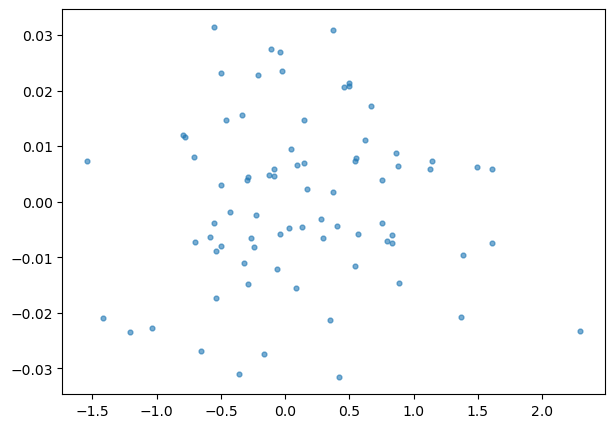

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

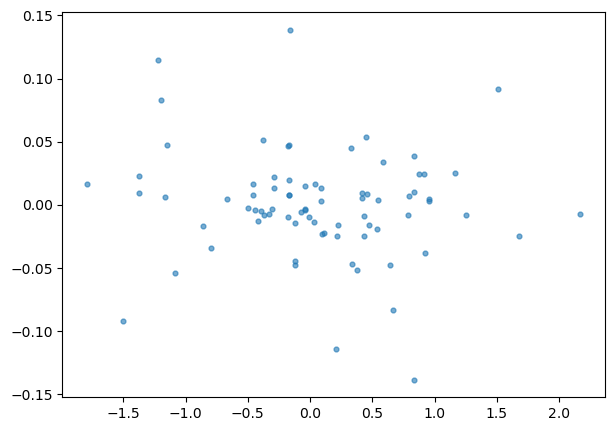

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

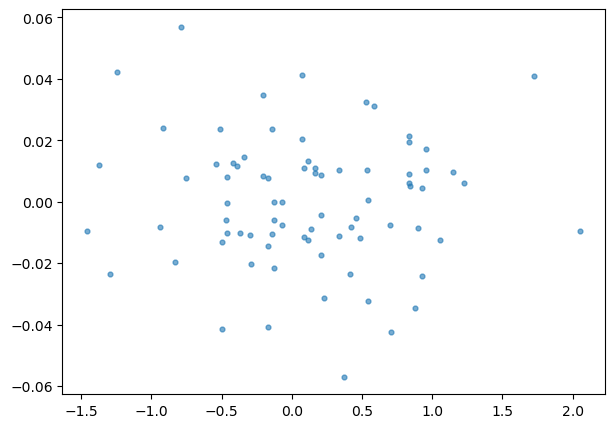

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

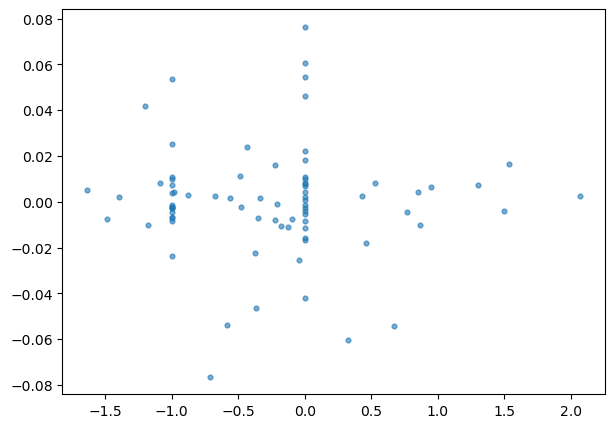

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

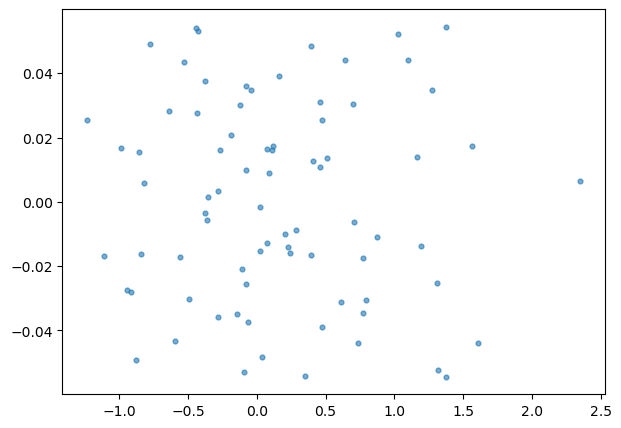

In [12]:
# ===============================================================
# 11) XAI: SHAP & LIME (SELECTED feature space)
# ===============================================================
if DO_EXPLAINERS:
    try:
        import shap
        from lime.lime_tabular import LimeTabularExplainer
        from scipy import sparse as sp
    except Exception as e:
        warnings.warn(f"Explainability packages not available; SHAP/LIME skipped: {e}")
        DO_EXPLAINERS = False

if DO_EXPLAINERS:

    def transform_until_estimator(pipe: Pipeline, X_in):
        Xt = X_in
        for name, step in pipe.named_steps.items():
            if name == 'clf':
                break
            Xt = step.transform(Xt)
            if sp.issparse(Xt):
                Xt = Xt.toarray()
        return Xt

    def get_selected_names_for_pipe(pipe: Pipeline, X_ref):
        mask, sel_names, sel_names_clean, _ = get_selected_feature_info(pipe, X_ref)
        return sel_names, sel_names_clean

    # Select runs around median AP per model for explanation
    def select_median_window(df_scores, model_name, window=2):
        dfm = df_scores[df_scores['model'] == model_name].sort_values('ap_test').reset_index(drop=True)
        if dfm.empty:
            return dfm
        k = len(dfm); mid = k // 2
        lo = max(0, mid - window); hi = min(k, mid + window + 1)
        return dfm.iloc[lo:hi][['model','rep','ap_test','auc_test']]

    WINDOW = 2
    df_scores_ap = pd.DataFrame(ap_records)
    selected_rows = {m: select_median_window(df_scores_ap, m, window=WINDOW) for m in model_names}

    sel_log = []
    for m, d in selected_rows.items():
        if d is None or d.empty: continue
        for _, r in d.iterrows():
            sel_log.append({'model': m, 'rep': int(r['rep']),
                            'ap_test': float(r.get('ap_test', np.nan)),
                            'auc_test': float(r.get('auc_test', np.nan))})
    if sel_log:
        pd.DataFrame(sel_log).to_csv(EXPL_DIR / "selected_runs_for_explanations.csv", index=False)

    BGN = 200   # background subsample (train+val)
    TSN = 50    # test subsample
    TOPK_DEP = 5

    for model_name in model_names:
        sel_df = selected_rows.get(model_name, pd.DataFrame())
        if sel_df is None or sel_df.empty:
            print(f"[WARN] {model_name}: no selected runs; skipping.")
            continue

        class_names = [str(c) for c in classes_sorted]
        safe_model = model_name.replace(" ", "")

        for _, row in sel_df.iterrows():
            rep = int(row['rep'])
            if rep not in split_store:
                print(f"[WARN] {model_name}: rep={rep} split not found; skipped.")
                continue

            idx_trainval = split_store[rep]['trainval_idx']
            idx_test     = split_store[rep]['test_idx']
            X_bg_full = X.iloc[idx_trainval]
            X_ts_full = X.iloc[idx_test]

            rng = np.random.default_rng(42)
            b_idx = rng.choice(len(X_bg_full), size=min(BGN, len(X_bg_full)), replace=False)
            t_idx = rng.choice(len(X_ts_full), size=min(TSN, len(X_ts_full)), replace=False)
            X_bg  = X_bg_full.iloc[b_idx]
            X_ts  = X_ts_full.iloc[t_idx]

            pipe = final_pipes[model_name][rep]
            clf  = pipe.named_steps['clf']
            pos_idx_local = int(np.where(clf.classes_ == pos_label)[0][0])

            # Transform into SELECTED feature space
            X_bg_sel = transform_until_estimator(pipe, X_bg)
            X_ts_sel = transform_until_estimator(pipe, X_ts)
            feat_names_sel, feat_names_sel_clean = get_selected_names_for_pipe(pipe, X)

            # SHAP
            model_type = type(clf).__name__.lower()
            use_kernel = False
            sv_arr = None

            try:
                if ("randomforest" in model_type) or ("xgb" in model_type) or ("xgboost" in model_type) or ("decisiontree" in model_type):
                    explainer = shap.TreeExplainer(clf)
                    shap_values = explainer.shap_values(X_ts_sel)
                    sv_arr = shap_values[pos_idx_local] if isinstance(shap_values, list) else shap_values
                elif "logisticregression" in model_type:
                    explainer = shap.LinearExplainer(clf, X_bg_sel)
                    shap_values = explainer.shap_values(X_ts_sel)
                    sv_arr = shap_values
                else:
                    use_kernel = True
            except Exception as e:
                warnings.warn(f"[INFO] {model_name} rep={rep}: Tree/Linear SHAP not applicable ({e}); using Kernel.")
                use_kernel = True

            if use_kernel:
                def proba_fn_sel(z):
                    z = np.asarray(z)
                    return clf.predict_proba(z)[:, pos_idx_local]
                explainer = shap.KernelExplainer(proba_fn_sel, X_bg_sel, link="logit")
                shap_values = explainer.shap_values(X_ts_sel, nsamples=2048)
                sv_arr = shap_values[pos_idx_local] if isinstance(shap_values, list) else shap_values

            # SHAP plots
            try:
                plt.figure(figsize=(9, 6))
                shap.summary_plot(sv_arr, features=None, feature_names=feat_names_sel_clean,
                                  plot_type="bar", show=False, max_display=20)
                plt.tight_layout()
                plt.savefig(EXPL_DIR / f"{safe_model}__rep{rep:02d}__shap_bar.png", dpi=150, bbox_inches='tight')
                plt.close()
            except Exception as e:
                warnings.warn(f"[WARN] {model_name} rep={rep} bar plot error: {e}")

            try:
                plt.figure(figsize=(9, 6))
                shap.summary_plot(sv_arr, X_ts_sel, feature_names=feat_names_sel_clean, show=False, max_display=20)
                plt.tight_layout()
                plt.savefig(EXPL_DIR / f"{safe_model}__rep{rep:02d}__shap_beeswarm.png", dpi=150, bbox_inches='tight')
                plt.close()
            except Exception as e:
                warnings.warn(f"[WARN] {model_name} rep={rep} beeswarm error: {e}")

            try:
                mean_abs = np.mean(np.abs(sv_arr), axis=0)
                top_idx = np.argsort(mean_abs)[::-1][:min(TOPK_DEP, len(mean_abs))]
                for j in top_idx:
                    xj = np.ravel(X_ts_sel[:, j]); yj = np.ravel(sv_arr[:, j])
                    m = min(xj.size, yj.size); xj = xj[:m]; yj = yj[:m]
                    mask_f = np.isfinite(xj) & np.isfinite(yj); xj = xj[mask_f]; yj = yj[mask_f]
                    if xj.size == 0: continue
                    plt.figure(figsize=(7, 5))
                    plt.scatter(xj, yj, s=12, alpha=0.6)
                    plt.xlabel(feat_names_sel_clean[j]); plt.ylabel("SHAP value")
                    plt.title(f"{model_name} rep={rep} — {feat_names_sel_clean[j]}")
                    plt.tight_layout()
                    plt.savefig(EXPL_DIR / f"{safe_model}__rep{rep:02d}__dep_feat{j}.png", dpi=150, bbox_inches='tight')
                    plt.close()
            except Exception as e:
                warnings.warn(f"[WARN] {model_name} rep={rep} dependence plot error: {e}")

            # LIME
            try:
                lime_expl = LimeTabularExplainer(
                    training_data=X_bg_sel,
                    feature_names=feat_names_sel_clean,
                    class_names=class_names,
                    mode='classification',
                    discretize_continuous=True
                )
                predict_fn_lime = lambda data: clf.predict_proba(np.asarray(data))
                for i in range(min(3, X_ts_sel.shape[0])):
                    exp = lime_expl.explain_instance(
                        X_ts_sel[i],
                        predict_fn_lime,
                        num_features=min(10, X_ts_sel.shape[1]),
                        labels=[pos_idx_local]
                    )
                    html = exp.as_html(labels=[pos_idx_local])
                    with open(LIME_DIR / f"{safe_model}__rep{rep:02d}__lime_idx{i}.html",
                              "w", encoding="utf-8") as f:
                        f.write(html)
            except Exception as e:
                warnings.warn(f"[WARN] {model_name} rep={rep} LIME error: {e}")

            print(f"[OK] {model_name} rep={rep}: SHAP/LIME saved with SELECTED features.")

print("\nAll steps completed successfully.")

In [13]:
# ============================================================
# 12) Selected features + frequency + best hyperparameters (LONG/WIDE)
# ============================================================
SEL_DIR = BASE_OUT_DIR / f"selected_features_{RUN_TAG}"
SEL_DIR.mkdir(parents=True, exist_ok=True)

def _clean_names_local(names):
    try:
        return clean_names(names)
    except NameError:
        out = []
        for n in names:
            n = str(n)
            out.append(n.split("__", 1)[1] if "__" in n else n)
        return out

def get_feature_names_after_prep_only(pipe, X_ref):
    pre = pipe.named_steps.get('prep', None)
    if pre is not None and hasattr(pre, "get_feature_names_out"):
        try:
            names = list(pre.get_feature_names_out(input_features=X_ref.columns))
        except Exception:
            try:
                names = list(pre.get_feature_names_out())
            except Exception:
                names = list(X_ref.columns)
    else:
        names = list(X_ref.columns)
    return names, _clean_names_local(names)

def safe_array(a, target_len):
    if a is None:
        return np.array([np.nan] * target_len, dtype=float)
    a = np.asarray(a)
    L = min(len(a), target_len)
    return np.asarray(a[:L], dtype=float)

# 1) Long table of selected features per run
rows = []
for model_name in model_names:
    for rep, pipe in (final_pipes.get(model_name, {}) or {}).items():
        names_trans, names_clean = get_feature_names_after_prep_only(pipe, X)
        feat = pipe.named_steps.get("feat", None)
        if feat is not None and hasattr(feat, "get_support"):
            mask   = feat.get_support()
            scores = getattr(feat, "scores_", None)
            pvals  = getattr(feat, "pvalues_", None)
        else:
            mask   = np.ones(len(names_trans), dtype=bool)
            scores = None
            pvals  = None

        L = len(names_trans)
        if len(mask) != L:
            L = min(L, len(mask))
            names_trans = names_trans[:L]
            names_clean = names_clean[:L]
            mask = mask[:L]
        scores = safe_array(scores, L)
        pvals  = safe_array(pvals,  L)

        # score-based ranking (descending)
        score_for_rank = np.nan_to_num(scores, nan=-np.inf)
        order = np.argsort(-score_for_rank)
        rank_map = {int(idx): int(r+1) for r, idx in enumerate(order)}
        k_selected = int(np.sum(mask))

        for i in range(L):
            cname = names_clean[i]
            idx_in_X = X.columns.get_loc(cname) if cname in X.columns else np.nan
            rows.append({
                "model": model_name,
                "rep": int(rep),
                "k_selected": k_selected,
                "feat_pos_after_prep": i,
                "feat_idx_in_X": int(idx_in_X) if idx_in_X == idx_in_X else np.nan,
                "feat_name_clean": cname,
                "feat_name_transformed": names_trans[i],
                "selected": bool(mask[i]),
                "score_f_classif": float(scores[i]) if scores[i] == scores[i] else np.nan,
                "p_value": float(pvals[i]) if pvals[i] == pvals[i] else np.nan,
                "rank_desc_score": rank_map.get(i, np.nan),
            })

df_selected_long = (pd.DataFrame(rows)
                    .sort_values(["model","rep","selected","rank_desc_score"],
                                 ascending=[True, True, False, True])
                    .reset_index(drop=True))

out_long = SEL_DIR / "selected_features_per_run_long.csv"
df_selected_long.to_csv(out_long, index=False)
print(f"[OK] Selected-features (long): {out_long}")

# 2) Selection frequency summary per model
freq_rows = []
if not df_selected_long.empty:
    for (model_name, feat), g in df_selected_long.groupby(["model", "feat_name_clean"]):
        n_runs = g["rep"].nunique()
        n_sel  = int(g.loc[g["selected"], "rep"].nunique())
        freq_rows.append({
            "model": model_name,
            "feature": feat,
            "n_runs": n_runs,
            "n_selected": n_sel,
            "selection_rate": (n_sel / n_runs) if n_runs > 0 else np.nan,
            "mean_score_selected": g.loc[g["selected"] & g["score_f_classif"].notna(), "score_f_classif"].mean(),
            "median_rank_among_all": g["rank_desc_score"].median()
        })

df_freq = (pd.DataFrame(freq_rows)
           .sort_values(["model","selection_rate","mean_score_selected"],
                        ascending=[True, False, False])
           .reset_index(drop=True))

out_freq = SEL_DIR / "selection_frequency_by_model.csv"
df_freq.to_csv(out_freq, index=False)
print(f"[OK] Selection frequency: {out_freq}")

# Plot top-15 by selection rate per model (for GitHub visuals)
PLOT_DIR = SEL_DIR / "plots"
PLOT_DIR.mkdir(parents=True, exist_ok=True)
for m in model_names:
    sub = df_freq[df_freq['model'] == m].copy()
    if sub.empty: continue
    sub = sub.sort_values('selection_rate', ascending=False).head(15)
    plt.figure(figsize=(8, 6))
    sns.barplot(data=sub, x='selection_rate', y='feature')
    plt.xlabel('Selection rate over 20 runs')
    plt.ylabel('Feature')
    plt.title(f'Top-15 selected features — {m} — {RUN_TAG}')
    plt.tight_layout()
    plt.savefig(PLOT_DIR / f"top_features_{m.replace(' ','_')}_{RUN_TAG}.png", dpi=200)
    plt.close()

# 3) Best hyperparameters — LONG and WIDE CSVs
def _flatten_dict(d, parent_key=""):
    items = []
    if d is None:
        return items
    for k, v in d.items():
        key = f"{parent_key}.{k}" if parent_key else str(k)
        if isinstance(v, dict):
            items.extend(_flatten_dict(v, key))
        else:
            items.append((key, v))
    return items

hp_long_rows = []
hp_wide_rows = []

for model_name in model_names:
    for rec in best_hyperparameters.get(model_name, []):
        rep = rec.get("rep", np.nan)
        bp    = rec.get("best_params", {}) or {}
        bps   = rec.get("best_params_structured", {}) or {}
        kbest = rec.get("k_best", None)
        valf1 = rec.get("val_f1", np.nan)
        valap = rec.get("val_ap", np.nan)
        valau = rec.get("val_auc", np.nan)
        opttg = rec.get("optimize_for", None)
        sel_list = rec.get("selected_feature_names_clean", None)

        # LONG
        meta = {
            "meta.val_f1": valf1, "meta.val_ap": valap, "meta.val_auc": valau,
            "meta.k_best": kbest, "meta.optimize_for": opttg,
            "meta.selected_features_joined": ";".join(map(str, sel_list)) if sel_list else None
        }
        for k, v in meta.items():
            hp_long_rows.append({"model": model_name, "rep": rep, "param": k, "value": v})
        for k, v in sorted(_flatten_dict(bp)):
            hp_long_rows.append({"model": model_name, "rep": rep, "param": f"best_params.{k}", "value": v})
        for k, v in sorted(_flatten_dict(bps)):
            hp_long_rows.append({"model": model_name, "rep": rep, "param": f"best_params_structured.{k}", "value": v})

        # WIDE
        wide_row = {"model": model_name, "rep": rep,
                    "val_f1": valf1, "val_ap": valap, "val_auc": valau,
                    "k_best": kbest, "optimize_for": opttg,
                    "selected_features_joined": ";".join(map(str, sel_list)) if sel_list else None}
        for k, v in _flatten_dict(bp, "best_params"):
            wide_row[k] = v
        for k, v in _flatten_dict(bps, "best_params_structured"):
            wide_row[k] = v
        hp_wide_rows.append(wide_row)

df_hp_long = pd.DataFrame(hp_long_rows).sort_values(["model","rep","param"]).reset_index(drop=True)
df_hp_wide = pd.DataFrame(hp_wide_rows).sort_values(["model","rep"]).reset_index(drop=True)

def _jsonify_non_scalars(df, col):
    def _to_json_if_needed(x):
        if isinstance(x, (list, tuple, dict)):
            try:
                return json.dumps(x, ensure_ascii=False)
            except Exception:
                return str(x)
        return x
    df[col] = df[col].apply(_to_json_if_needed)

if not df_hp_long.empty:
    _jsonify_non_scalars(df_hp_long, "value")

out_hp_long = SEL_DIR / "best_hyperparameters_long.csv"
out_hp_wide = SEL_DIR / "best_hyperparameters_wide.csv"
df_hp_long.to_csv(out_hp_long, index=False)
df_hp_wide.to_csv(out_hp_wide, index=False)
print(f"[OK] Best hyperparameters (long): {out_hp_long}")
print(f"[OK] Best hyperparameters (wide): {out_hp_wide}")

# Also persist the full dict as JSON (already saved earlier under OUT_DIR)
bhp_json_out = SEL_DIR / "best_hyperparameters_with_selected_features.json"
try:
    with open(bhp_json_out, "w", encoding="utf-8") as f:
        json.dump(best_hyperparameters, f, ensure_ascii=False, indent=2)
    print(f"[OK] JSON snapshot (bhp+selected): {bhp_json_out}")
except Exception as e:
    print(f"[WARN] JSON write skipped: {e}")

print("\n[REPORT]")
print(f"  - Selected features (long): {out_long}")
print(f"  - Selection frequency      : {out_freq}")
print(f"  - Best HP (long)           : {out_hp_long}")
print(f"  - Best HP (wide)           : {out_hp_wide}")
print(f"  - JSON snapshot            : {bhp_json_out}")


[OK] Selected-features (long): C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\selected_features_OBJ_ap\selected_features_per_run_long.csv
[OK] Selection frequency: C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\selected_features_OBJ_ap\selection_frequency_by_model.csv
[OK] Best hyperparameters (long): C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\selected_features_OBJ_ap\best_hyperparameters_long.csv
[OK] Best hyperparameters (wide): C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\selected_features_OBJ_ap\best_hyperparameters_wide.csv
[OK] JSON snapshot (bhp+selected): C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\selected_features_OBJ_ap\best_hyperparameters_with_selected_features.json

[REPORT]
  - Selected features (long): C:\Users\gokalp\Desktop\TN METRIC CALISMAnew\31102025\with_feature_selection3\selected_features_OBJ_ap\selec